# Decision Tree

## 0. Setup

### 0.1. Load packages

In [1]:
# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

from panelsplit.cross_validation import PanelSplit

import shap
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import zipfile
import openpyxl

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit  # Alternative to PanelSplit

c:\Users\mmier\anaconda3\envs\MDS_thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.2. Load Data

In [2]:
### Check working directory
#print(os.getcwd()) 

### Define file and path
#file_path = r"c:\Users\mmier\OneDrive - Hertie School\3. Estudio\2025 MDS\2025-1 MDS Thesis\MDS_thesis\Data" #Use a raw string (r"") when defining paths
#print(os.listdir(file_path)) # List files in directory
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"
#full_path = os.path.join(file_path, csv_filename)

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

# Feature names
#final_df_feature_names = list(final_df.columns) 
#print(final_df_feature_names)

### 0.3. Define y and X1

In [3]:
# y 
y = final_df['pc_loss']
y = np.log1p(final_df['pc_loss'])
#y = y.to_numpy()

# Normalize output
#scaler = StandardScaler()
# y = scaler.fit_transform(y.values.reshape(-1, 1))

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp']) # GDP, area already out since the were already considered
X1 = X1.drop(columns=['CV-01-15','CV-03-64', 'CV-03-26b', 'CV-01-11', 'CV-01-1', 'PCC-02-0', 'PCC-02-3', 'EIS-00-0', 'PCC-00-0', 'CTI-00-0', 'C-02-8t', 'ICM-00-0',
                      'EIS-03-4', 'CTI-01-3', 'SEG-00-0', 'SEG-01-6', 'SOS-00-0', 'SOS-02-0', 'SOS-02-2', 'SOS-01-6', 'GPI-00-0', 'GPI-02-4', 'GPI-02-5', 'P-01-34-1',
                      'P-01-46', 'P-01-25', 'CV-02-12e', 'CV-03-51', 'total_ac', 'e_minas_anti']) 
print(len(X1.columns))

# Keep feature names
original_feature_names = list(X1.columns) 
#print(original_feature_names)

# Normalize features
#X1 = scaler.fit_transform(X1)

70


## 1. Decision Tree

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Define hyperparameters to test
max_depth_values = [3, 5, 10, 20, None]
results_dt = {}

# Setup panel cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)

# Loop through cross-validation splits
for train_idx, test_idx in panel_split.split(X1, y):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for max_depth in max_depth_values:
        model = DecisionTreeRegressor(max_depth=max_depth, random_state=17)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)

        n_train, k = X_train.shape
        n_test = X_test.shape[0]

        # Store fold results
        if max_depth not in results_dt:
            results_dt[max_depth] = []

        results_dt[max_depth].append({
            "MSE": mse_test,
            "RMSE": rmse_test,
            "MAE": mae_test,
            "R2_train": r2_train,
            "R2_test": r2_test
        })

# Average results across folds
averaged_results_dt = {
    depth: {metric: np.mean([fold[metric] for fold in folds])
            for metric in folds[0].keys()}
    for depth, folds in results_dt.items()
}

# Find best max_depth based on lowest MSE
best_depth = min(averaged_results_dt, key=lambda d: averaged_results_dt[d]["MSE"])
best_metrics = averaged_results_dt[best_depth]

# Print results
print(f"🌳 Best Decision Tree Depth: {best_depth}")
print(f"📊 MSE: {best_metrics['MSE']:.4f}")
print(f"📊 RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")


🌳 Best Decision Tree Depth: 5
📊 MSE: 0.0083
📊 RMSE: 0.0907
📊 MAE: 0.0469
📊 R² (Train): 0.4089
📊 R² (Test): 0.3378


In [5]:
np.unique(y_test_pred)

array([0.00000000e+00, 3.64075061e-05, 1.20994693e-04, 4.68990457e-04,
       6.92057146e-04, 1.04167902e-03, 1.16531752e-03, 1.34699720e-03,
       1.38907793e-03, 1.68013240e-03, 1.76109018e-03, 1.86746767e-03,
       1.91942262e-03, 2.01097417e-03, 2.03000806e-03, 2.29714908e-03,
       2.39554858e-03, 2.41639449e-03, 2.44252655e-03, 2.56558245e-03,
       2.61413294e-03, 2.63341251e-03, 2.67690641e-03, 2.68139929e-03,
       2.96718384e-03, 3.22560166e-03, 3.26066134e-03, 3.30318802e-03,
       3.30517528e-03, 3.33848280e-03, 3.40013830e-03, 3.44077099e-03,
       3.51010579e-03, 3.51399646e-03, 3.51952989e-03, 3.56680966e-03,
       3.62240565e-03, 3.73669401e-03, 3.76334206e-03, 3.76702930e-03,
       3.93792177e-03, 3.99640615e-03, 4.13615453e-03, 4.13757906e-03,
       4.20114955e-03, 4.25385696e-03, 4.26141194e-03, 4.32861621e-03,
       4.35138747e-03, 4.36159063e-03, 4.38269246e-03, 4.49761326e-03,
       4.50617790e-03, 4.50740623e-03, 4.52679784e-03, 4.53147120e-03,
      

## 2. Manual grid tunning

In [6]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from itertools import product

## Define hyperparameter grids
max_depth_values = [3, 5, 10, 20, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]
ccp_alpha_values = [0.0, 0.001, 0.01]

# Setup panel-aware cross-validation
panel_split = PanelSplit(periods=final_df['year'], n_splits=5, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped
results_dt = {}

# Grid search with cross-validation
param_combinations = product(max_depth_values, min_samples_split_values, min_samples_leaf_values, ccp_alpha_values)

for train_idx, test_idx in panel_split.split(X1, y):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    for max_depth, min_samples_split, min_samples_leaf, ccp_alpha in param_combinations:
        model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            ccp_alpha=ccp_alpha,
            random_state=17
        )
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)

        n_train, k = X_train.shape
        n_test = X_test.shape[0]

        params_key = (max_depth, min_samples_split, min_samples_leaf, ccp_alpha)
        if params_key not in results_dt:
            results_dt[params_key] = []

        results_dt[params_key].append({
            "MSE": mse_test,
            "RMSE": rmse_test,
            "MAE": mae_test,
            "R2_train": r2_train,
            "R2_test": r2_test
        })

# Compute average performance
averaged_results_dt = {
    params: {metric: np.mean([fold[metric] for fold in folds])
             for metric in folds[0].keys()}
    for params, folds in results_dt.items()
}

# Find best parameter combination
best_params = min(averaged_results_dt, key=lambda d: averaged_results_dt[d]["MSE"])
best_metrics = averaged_results_dt[best_params]

# Retrain best model on full dataset
best_model = DecisionTreeRegressor(
    max_depth=best_params[0],
    min_samples_split=best_params[1],
    min_samples_leaf=best_params[2],
    ccp_alpha=best_params[3],
    random_state=17
)
best_model.fit(X1, y)

# Print results
print(f"✅ Decision tree with PanelSplit Results:")
print(f"📊 MSE: {best_metrics['MSE']:.4f}")
print(f"📊 RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print(f"🌳 Best Parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}, min_samples_leaf={best_params[2]}, ccp_alpha={best_params[3]}")


✅ Decision tree with PanelSplit Results:
📊 MSE: 0.0093
📊 RMSE: 0.0964
📊 MAE: 0.0553
📊 R² (Train): 0.1094
📊 R² (Test): 0.2335
🌳 Best Parameters: max_depth=3, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0.001


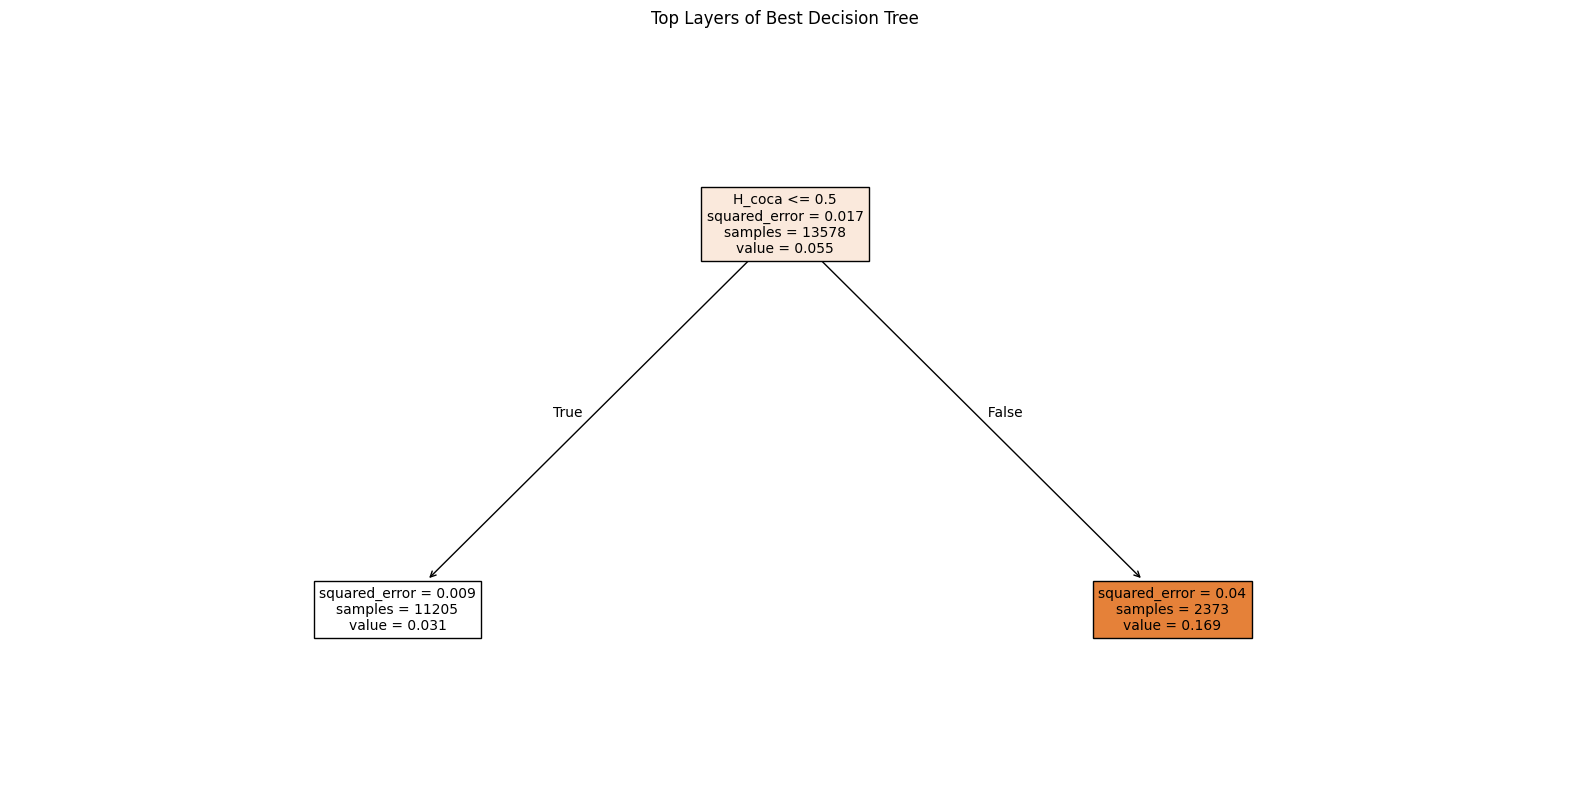

In [7]:
# Plot top layers of the best tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns, filled=True, max_depth=3, fontsize=10)
plt.title("Top Layers of Best Decision Tree")
plt.show()

## 3. GridSearchCV

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Define hyperparameter grid for DecisionTreeRegressor
param_grid = {
    "max_depth": [5, 10, 20, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4],
    "ccp_alpha": [0.0, 0.001, 0.01]
}

# Define the model (no hyperparameters here — GridSearchCV will handle it)
model = DecisionTreeRegressor(random_state=17)


### Setup panel data cross-validation
panel_split = PanelSplit(periods=final_df.year, n_splits=3, gap=0, test_size=1)
groups = X1.index  # Using index since Municipio was dropped


# Setup GridSearchCV with PanelSplit cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Minimize MSE
    cv=panel_split.split(X1, y),  # Custom panel CV
    n_jobs=-1,  # Parallel computation
    verbose=2
)

# Run grid search
grid_search.fit(X1, y)

# Extract best model and hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Store results for best hyperparameters
results = []

# Iterate through each fold for evaluation
for train_idx, test_idx in panel_split.split(X1, y):
    # Split data
    X1_train, X1_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the best model on the current fold
    best_model.fit(X1_train, y_train)

    # Make predictions
    y_train_pred = best_model.predict(X1_train)
    y_test_pred = best_model.predict(X1_test)

    # Compute performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Compute Adjusted R²
    n_train, k = X1_train.shape
    n_test = X1_test.shape[0]

    # Store results
    results.append({
        "MSE": mse_test,
        "RMSE": rmse_test,
        "MAE": mae_test,
        "R2_train": r2_train,
        "R2_test": r2_test
    })

# Compute average performance across folds
best_metrics = {metric: np.mean([fold[metric] for fold in results]) for metric in results[0].keys()}

### Print optimal hyperparameters and performance
#print(f"🌲 Best Random Forest Parameters: n_estimators={best_params['n_estimators']}, max_depth={best_params['max_depth']}")
#print(f"✅ Best Overall Parameters: {best_model['params']}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}")
print("✅ Best Decision Tree Parameters:")
for param, value in best_params.items():
    print(f"   - {param}: {value}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
📊 Best MSE: 0.0078
📊 Best RMSE: 0.0877
📊 Best MAE: 0.0408
📊 R² (Train): 0.7391
📊 R² (Test): 0.3696
✅ Best Decision Tree Parameters:
   - ccp_alpha: 0.0
   - max_depth: 10
   - min_samples_leaf: 1
   - min_samples_split: 10


Number of leaves: 208
Tree depth: 10


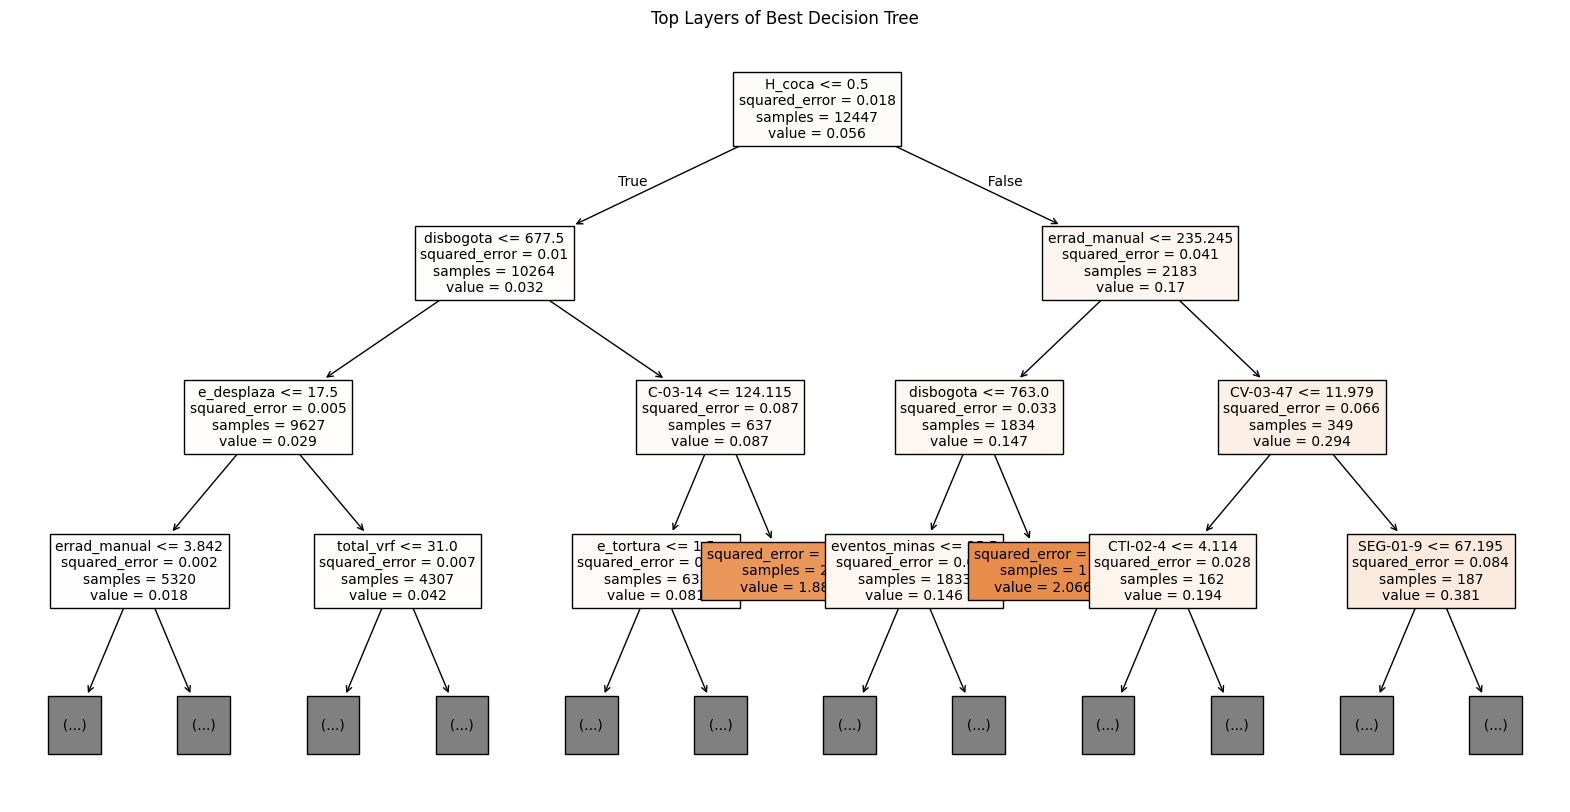

({'ccp_alpha': 0.0,
  'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 10},
 {'MSE': np.float64(0.007768076582685977),
  'RMSE': np.float64(0.0877397343963764),
  'MAE': np.float64(0.040776548240478674),
  'R2_train': np.float64(0.7390801344947816),
  'R2_test': np.float64(0.36964148029062177)})

In [9]:
np.unique(y_test_pred)

# Print tree structure info
print("Number of leaves:", best_model.get_n_leaves())
print("Tree depth:", best_model.get_depth())

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns, filled=True, max_depth=3, fontsize=10)
plt.title("Top Layers of Best Decision Tree")
plt.show()

# Display final best parameters and metrics
best_params, best_metrics

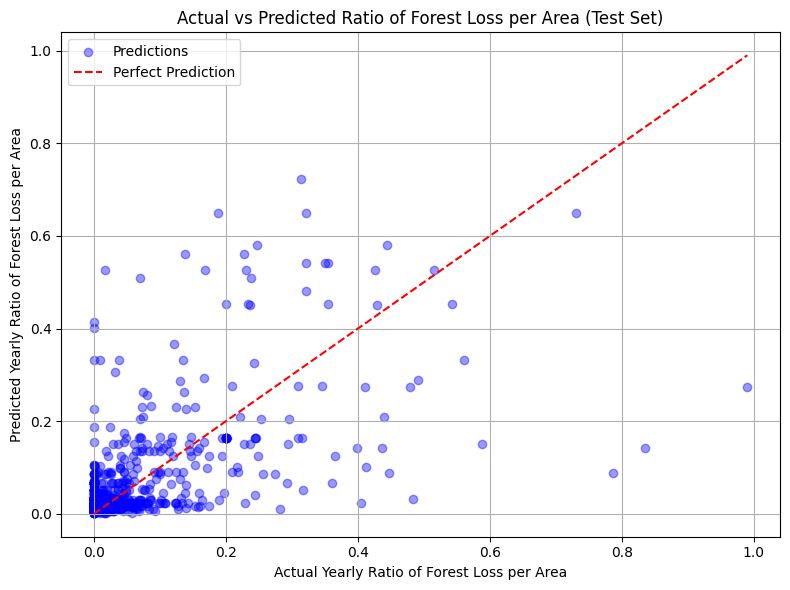

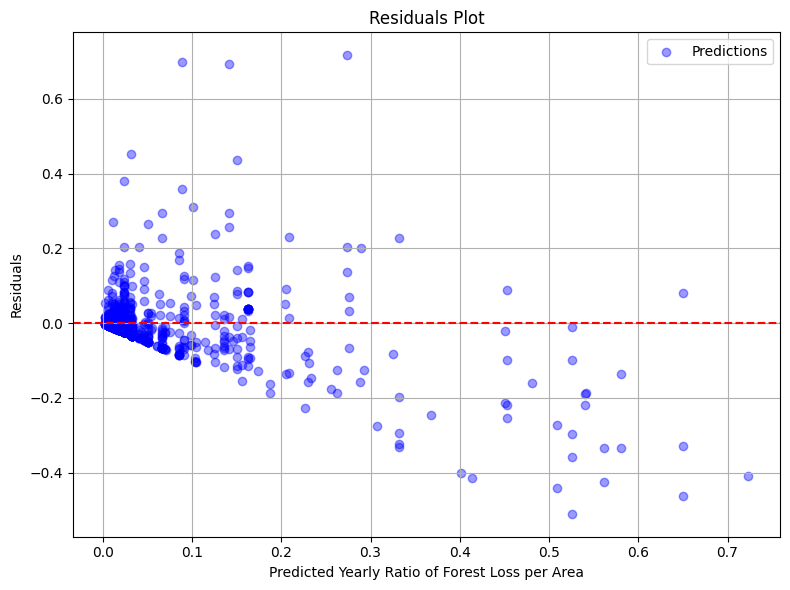

In [10]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yearly Ratio of Forest Loss per Area")
plt.ylabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.title("Actual vs Predicted Ratio of Forest Loss per Area (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("Predicted Yearly Ratio of Forest Loss per Area")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. SHAP analysis

Text(0.5, 1.0, 'Decision tree - mena absolut SHAP values (Top 10 Features)')

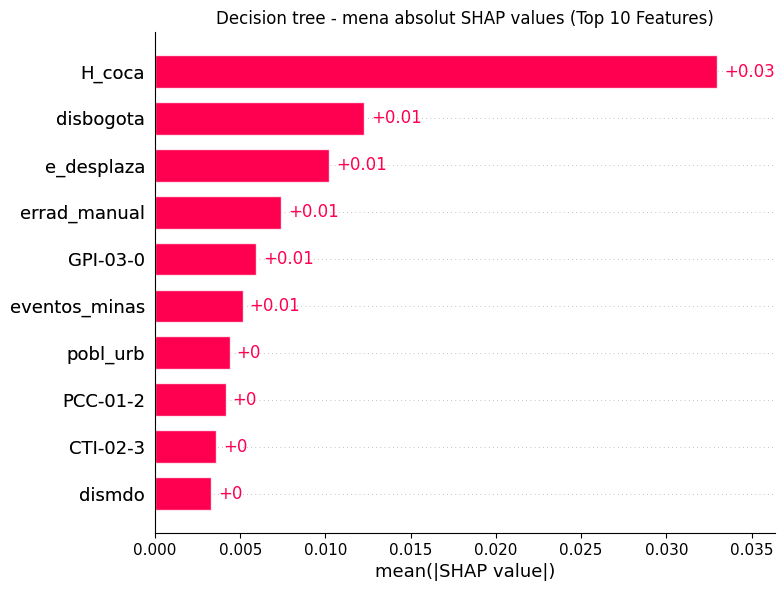

In [23]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X1)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Decision tree - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


Text(0.5, 1.0, 'Decision tree - mena absolut SHAP values (Top 10 Features)')

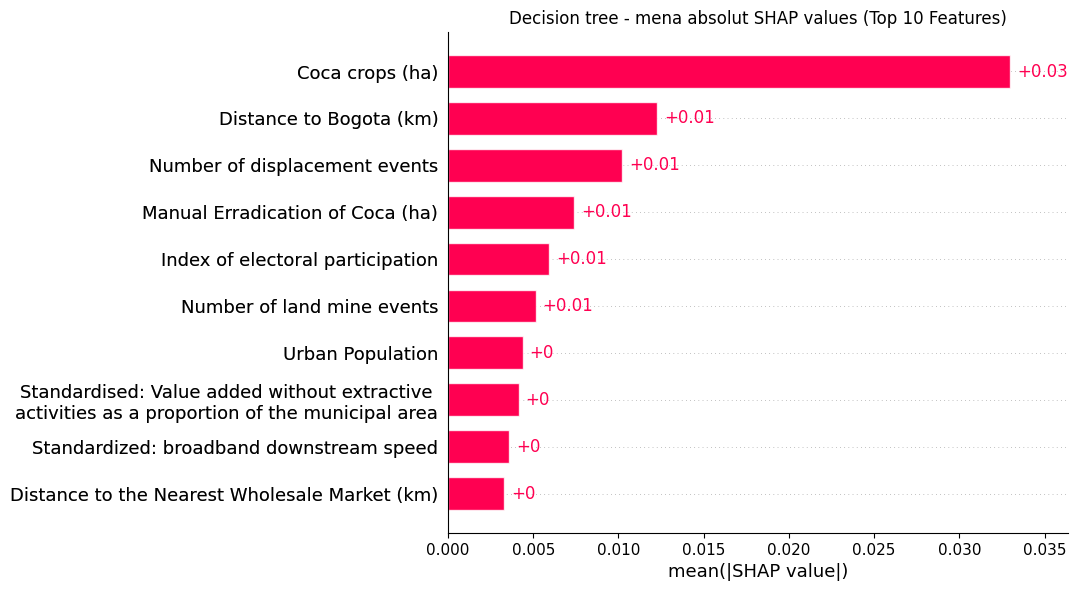

In [ ]:
# names
#    "H_coca": "Coca crops (ha)",
#    "disbogota": "Distance to Bogota (km)",


#    "PCC-01-2": "Standardised: Value added without extractive \nactivities as a proportion of the municipal area", 
#    "errad_manual": "Manual Erradication of Coca (ha)", 
#    "e_desplaza": "Number of displacement events",
#    "GPI-03-0": "Index of eectoral participation",
#    "eventos_minas": "Landmine events",
#    "dismdo": "Distance to the nearest wholesale market (km)",
#    "discapital": "Distance to capital of the Department (km)",
#    "PCC-02-3a": "Standardised: Payload-distance (Ton-Km)",
#    "eventos_minas": "Number of land mine events",
#    "pobl_urb": "Urban Population",
#    "GPI-03-0": "Index of participation",
#    "CTI-02-3": "Standardized: broadband downstream speed"


# Fixed names
custom_feature_names = [
    "Coca crops (ha)",
    "Distance to Bogota (km)",
    "Number of displacement events",
    "Manual Erradication of Coca (ha)", 
    "Index of electoral participation",
    "Number of land mine events",
    "Urban Population",
    "Standardised: Value added without extractive \nactivities as a proportion of the municipal area",
    "Standardized: broadband downstream speed", 
    "Distance to the Nearest Wholesale Market (km)"
]
custom_feature_names = [custom_feature_names[i] for i in range(len(custom_feature_names)-1, -1, -1)]

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]
top_10_indices

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=custom_feature_names  # Correct feature names
)


# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10, show=False)
plt.title("Decision tree - mena absolut SHAP values (Top 10 Features)")
# “The absolute contribution of coca crops to the model’s predictions corresponds to an average shift of about 0.02 on the log(1 + yearly forest loss per capita) scale, 
# which translates to roughly a 2% multiplicative effect on (1 + yearly forest loss per capita).”


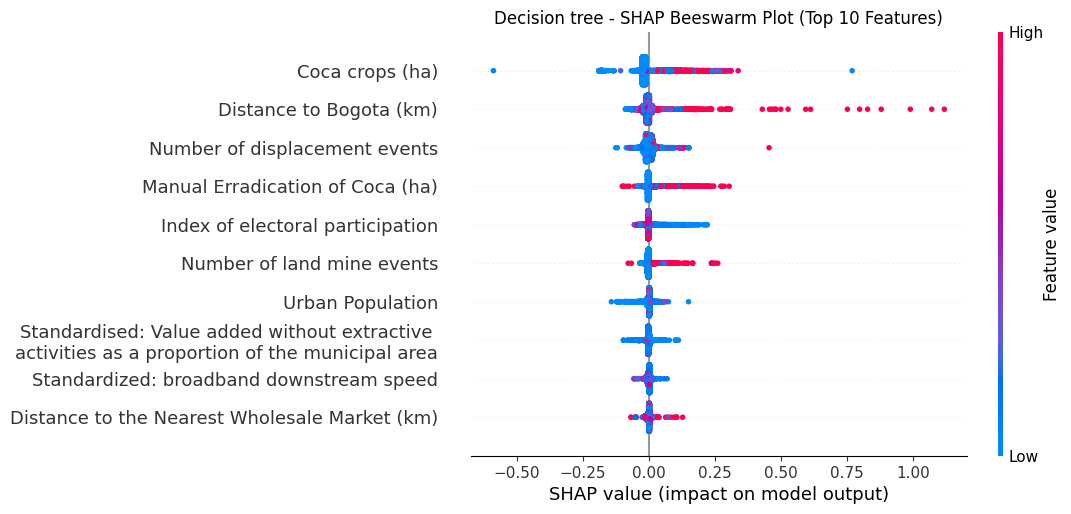

In [25]:
plt.figure(figsize=(16, 10))  
shap.plots.beeswarm(shap_values_top10, show=False)
plt.title("Decision tree - SHAP Beeswarm Plot (Top 10 Features)")
plt.show()
# “For some observations with high values of H_coca, the model’s prediction of yearly forest loss per capita can be up to about 25% higher than the model’s baseline 
# prediction (once we convert the SHAP value from the log(1 + y) scale back to the original scale).”

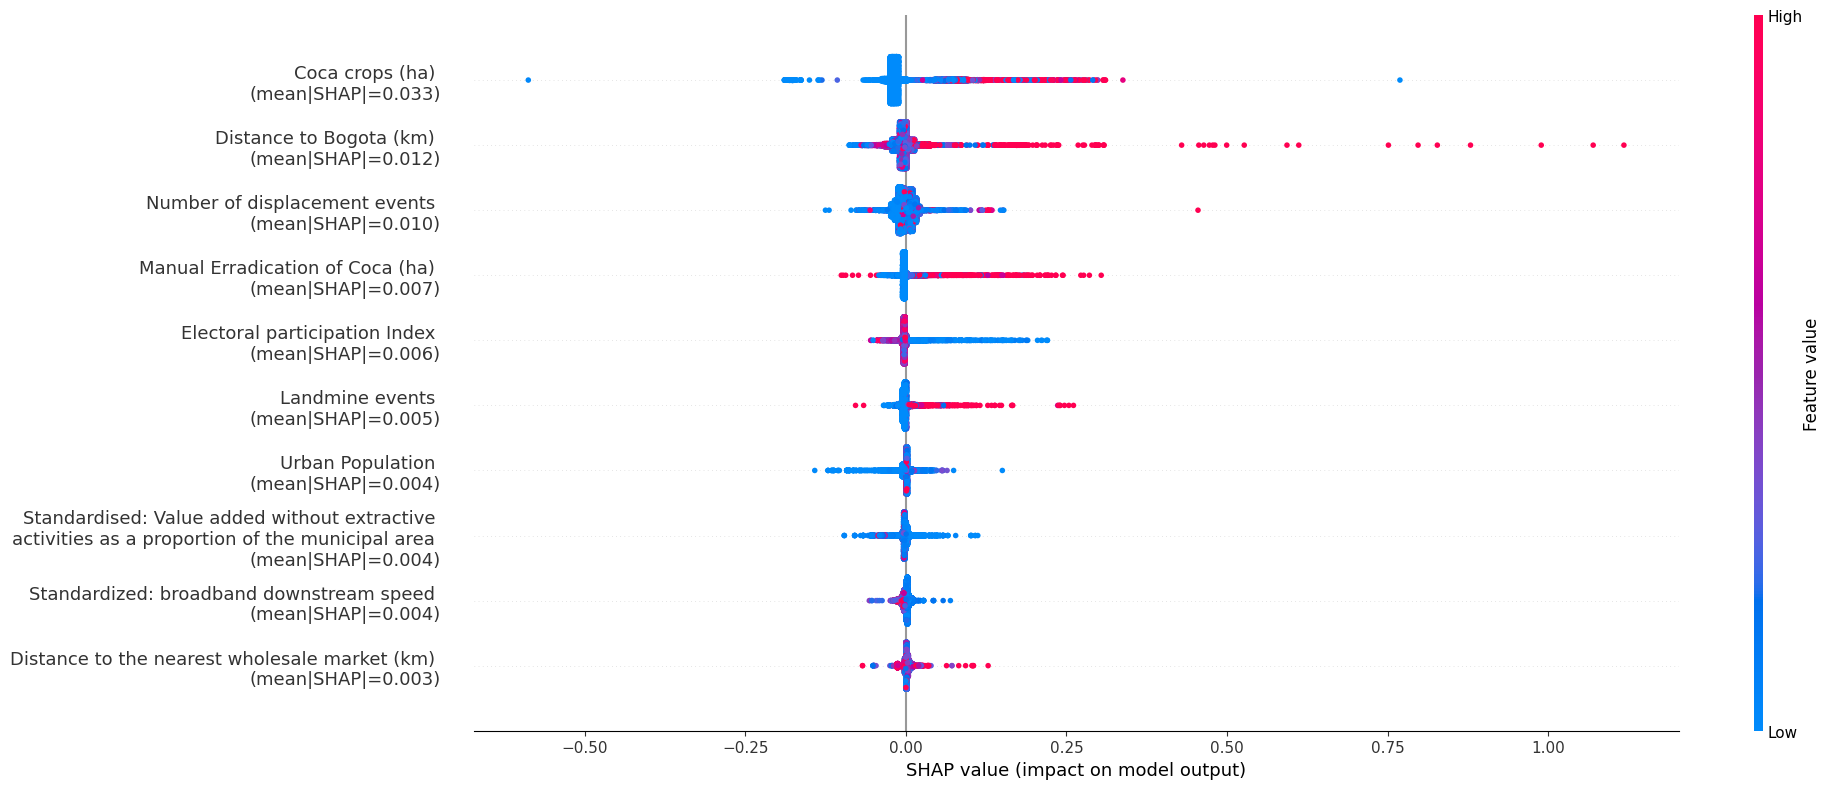

In [26]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1. Dictionary to rename original features
rename_dict = {
    "H_coca": "Coca crops (ha)",
    "disbogota": "Distance to Bogota (km)",
    "PCC-01-2": "Standardised: Value added without extractive \nactivities as a proportion of the municipal area", 
    "errad_manual": "Manual Erradication of Coca (ha)", 
    "e_desplaza": "Number of displacement events",
    "GPI-03-0": "Electoral participation Index",
    "eventos_minas": "Landmine events",
    "dismdo": "Distance to the nearest wholesale market (km)",
    "discapital": "Distance to capital of the Department (km)",
    "PCC-02-3a": "Standardised: Payload-distance (Ton-Km)",     

    "pobl_urb": "Urban Population",
    "CTI-02-3": "Standardized: broadband downstream speed", 
}

# 2. Original feature names (as passed to the model)
original_feature_names = shap_values.feature_names  # or X.columns.tolist()

# 3. Compute mean absolute SHAP values
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# 4. Get indices of top 10 features by importance (descending)
top_10_indices = np.argsort(shap_abs_mean)[-10:]
mean_abs_shap = shap_abs_mean[top_10_indices]

# 5. Rename features using the dictionary
top_10_feature_names = [rename_dict.get(original_feature_names[i], original_feature_names[i]) for i in top_10_indices]

# 6. Annotate names with mean SHAP values
annotated_names = [
    f"{name} \n(mean|SHAP|={mean_val:.3f})"
    for name, mean_val in zip(top_10_feature_names, mean_abs_shap)
]

# 7. Create the Explanation object
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],
    base_values=shap_values.base_values,
    data=shap_values.data[:, top_10_indices],
    feature_names=annotated_names
)

# 9. Plot beeswarm chart
shap.plots.beeswarm(shap_values_top10, plot_size=(20, 8), show=False)
plt.title("")
plt.tight_layout()
plt.show()